In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers, regularizers, Input
plt.rcParams["axes.grid"] = False


In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [3]:
#try same model with resizing
dim = (100,100)

In [4]:
#loading the data using the kaggle fcn
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../../../../archive/seg_train/seg_train', '../../../../archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dim) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [71]:
(train_images_resized_100, train_labels), (test_images_resized_100, test_labels) = load_data()

  2%|▏         | 49/2191 [00:00<00:04, 489.57it/s]

Loading ../../../../archive/seg_train/seg_train


100%|█████████▉| 2185/2191 [00:02<00:00, 833.28it/s]


KeyboardInterrupt: 

In [6]:
#normalize the images
train_images_resized_scaled_100 =train_images_resized_100.astype('float32') / 255.0
test_images_resized_scaled_100 = test_images_resized_100.astype('float32') / 255.0

In [8]:
train_images_resized_scaled_100.shape

(14034, 100, 100, 3)

In [14]:
from sklearn.cluster import MiniBatchKMeans

In [15]:
def color_compress_KNN(data, KNN=4):
    import warnings; warnings.simplefilter('ignore') 
    Kmeans_images = []
    data_train = data / 255.0 # use 0...1 scale
    data_train = data_train.reshape(data.shape[0], 100 * 100, 3)
    for i in tqdm(range(data_train.shape[0])):
        kmeans = MiniBatchKMeans(KNN)
        kmeans.fit(data_train[i])
        new_colors = None
        new_colors = kmeans.cluster_centers_[kmeans.predict(data_train[i])]
        new_image = new_colors.reshape(data[i].shape)
        Kmeans_images.append(new_image)
    print("Ding! Fries are done")
    return Kmeans_images

In [16]:
cck_train_100 = color_compress_KNN(train_images_resized_100,8)

100%|██████████| 14034/14034 [20:08<00:00, 11.62it/s]

Ding! Fries are done


In [24]:
from numpy import asarray
from numpy import savez_compressed
savez_compressed('cck_train_100.npz', np.asarray(cck_train_100))



In [31]:
cck_train_100 = np.load('cck_train_100.npz')['arr_0']


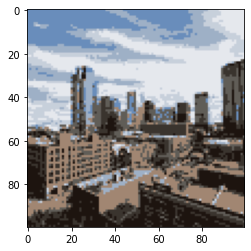

In [32]:
plt.imshow(cck_train_100[1])

In [36]:
cck_train_100.shape

(14034, 100, 100, 3)

In [37]:
cck_test_100 = color_compress_KNN(test_images_resized_100,8)

100%|██████████| 3000/3000 [04:17<00:00, 11.65it/s]


Ding! Fries are done


(3000, 100, 100, 3)

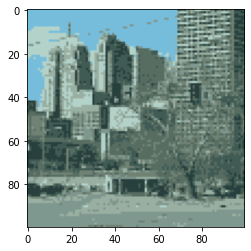

In [38]:
savez_compressed('cck_test_100.npz', np.asarray(cck_test_100))
cck_test_100 = np.load('cck_test_100.npz')['arr_0']
plt.imshow(cck_test_100[1])
cck_test_100.shape

In [39]:
#reshaping
def reshaper(array_of_imgs,height,width):
    '''
    Takes an array of RGB images and the reshaped height and width as ints. Reshapes each image to the new size and returns a new array of reshaped images.
    '''
    new_shape = np.full((len(array_of_imgs),height,width,3),None)
    for i in range(0,len(array_of_imgs),1):
        new_shape[i] = cv2.resize(array_of_imgs[i],(height,width))
    return new_shape

In [40]:
test_clustered_reshaped = reshaper(cck_test_100,100,100).astype('float32')
train_clustered_reshaped = reshaper(cck_train_100,100,100).astype('float32')

In [41]:
test_clustered_reshaped.shape

(3000, 100, 100, 3)

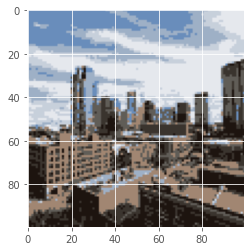

In [53]:
plt.imshow(train_clustered_reshaped[1])

In [42]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [65]:
layers_list = []

def modeler(layers_list,dims):
    
    model = models.Sequential()
    model.add(layers.InputLayer(dims))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu'))

    
    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(40,activation='relu'))

    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [66]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5,summary=False):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    if summary:
        return model.summary()
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [67]:
layers_list = [layers.Conv2D(128,(2,2),activation='relu'),
               layers.AveragePooling2D(2,2),
               layers.SpatialDropout2D(0.2),
               layers.Conv2D(128,(2,2),activation='relu',kernel_regularizer=regularizers.l2(l2=0.30)),
               layers.Dropout(0.2)
               ]

model = modeler(layers_list,(100,100,3))

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 99, 99, 128)       1664      
_________________________________________________________________
average_pooling2d (AveragePo (None, 49, 49, 128)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 128)       65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 294912)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 40)               

In [69]:
history = model_trainer(model,'4th-color_comp',
                        train_clustered_reshaped,train_labels,
                        test_clustered_reshaped,test_labels,
                        batch_size=32,
                        epochs=20,
                        summary=False)

Epoch 1/20
439/439 [==============================] - 174s 397ms/step - loss: 3.9026 - acc: 0.5064 - val_loss: 1.1278 - val_acc: 0.5823
Epoch 2/20
439/439 [==============================] - 176s 402ms/step - loss: 1.0414 - acc: 0.6289 - val_loss: 1.0178 - val_acc: 0.6120
Epoch 3/20
439/439 [==============================] - 176s 401ms/step - loss: 0.9675 - acc: 0.6536 - val_loss: 0.9476 - val_acc: 0.6530
Epoch 4/20
439/439 [==============================] - 180s 410ms/step - loss: 0.9277 - acc: 0.6665 - val_loss: 0.9122 - val_acc: 0.6847
Epoch 5/20
439/439 [==============================] - 178s 406ms/step - loss: 0.9022 - acc: 0.6804 - val_loss: 1.0063 - val_acc: 0.6347
Epoch 6/20
439/439 [==============================] - 179s 407ms/step - loss: 0.8730 - acc: 0.6899 - val_loss: 0.9113 - val_acc: 0.6777
Epoch 7/20
439/439 [==============================] - 176s 400ms/step - loss: 0.8576 - acc: 0.6960 - val_loss: 0.8829 - val_acc: 0.6817
Epoch 8/20
439/439 [============================

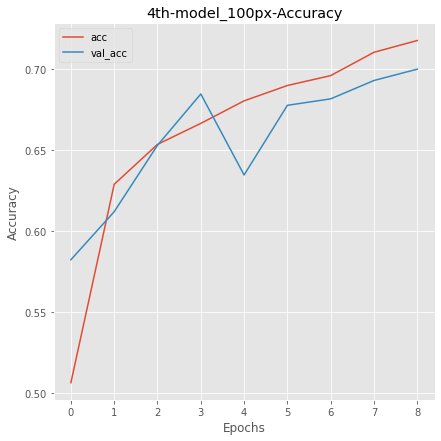

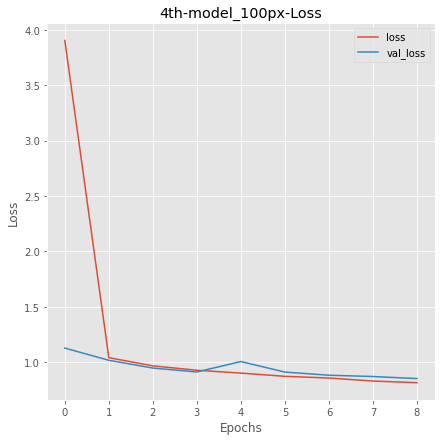

In [70]:
model_plots(history,'4th-model_100px')

This model manages overfitting well, but still can't get past about 70% accuracy. I'm Goin to explore other network structures in another notebook.